In [21]:
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import os
from statsmodels.tsa.stattools import adfuller
from scipy.stats import normaltest
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.utils.plotting import plot_series , plot_windows , plot_acf , plot_pacf , plot_correlations 

In [22]:
raiz = "C:/Users/henri/Downloads/Bases_clima_SCS"
lista_nomes = os.listdir(raiz)
lista_df_aux = []
for nome in lista_nomes:
    df_aux = pd.read_csv(raiz+"/"+nome,index_col=False)
    lista_df_aux.append(df_aux)
df_final = pd.concat(lista_df_aux)    

In [23]:
colunas_val = df_final.columns[df_final.columns.str.endswith("x") | df_final.columns.str.endswith("y")]
df_final_slim = df_final.drop(columns = colunas_val)
df_final_slim = df_final_slim.drop(columns = [df_final_slim.columns[0],"precipitacao_acc"])
df_final_slim["Date"] = pd.to_datetime(df_final["umidade_relativa_y"])
#df_final_slim.drop_duplicates(subset=["Date"])
df_final_slim.set_index("Date",inplace=True)

In [24]:
# Agrupando as datas #
#df_final_slim = df_final_slim.resample("1H").agg({"precipitacao":"sum","temperatura":"mean","temperatura_aparente":"mean","umidade_relativa":"mean","pressao":"mean"})

<AxesSubplot:xlabel='Date'>

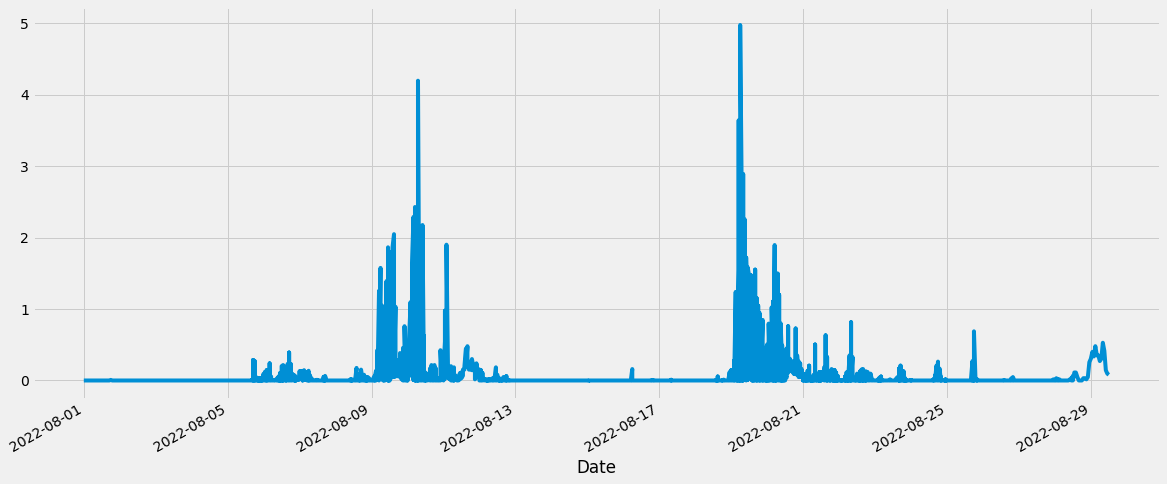

In [25]:
# Grafico Simples
df_final_slim["precipitacao"].plot(kind = "line")

<AxesSubplot:>

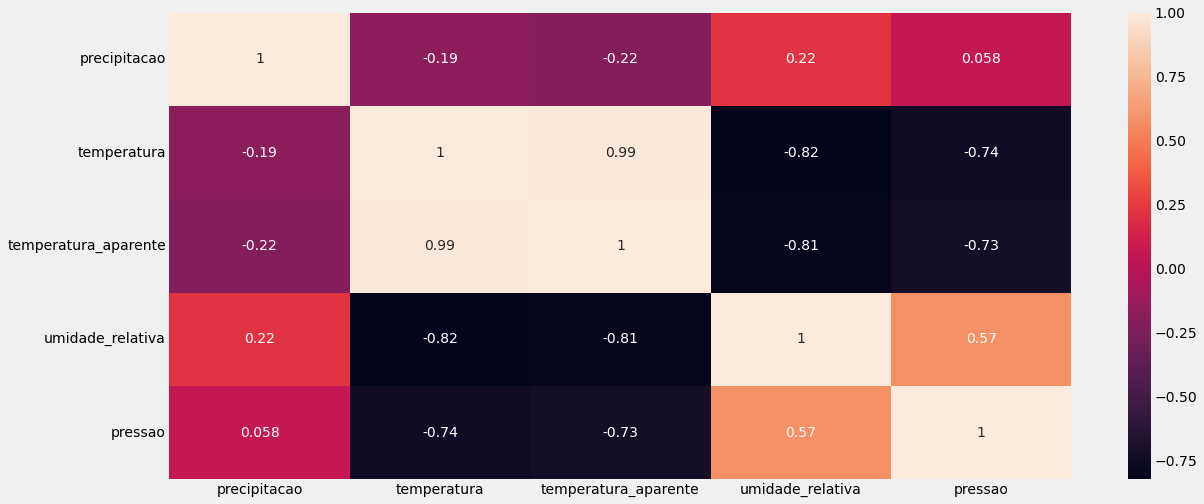

In [26]:
### Correlação

## Notas do modeleiro firmeza
#1) menos temperatura mais chance de chuva,oposto para umidade
#2) Pressão está muito baixo para considerar

sns.heatmap(df_final_slim.corr(),annot  = True)

In [27]:
df_final_slim.index.unique()

DatetimeIndex(['2022-08-01 00:00:00', '2022-08-01 01:00:00',
               '2022-08-01 02:00:00', '2022-08-01 03:00:00',
               '2022-08-01 04:00:00', '2022-08-01 05:00:00',
               '2022-08-01 06:00:00', '2022-08-01 07:00:00',
               '2022-08-01 08:00:00', '2022-08-01 09:00:00',
               ...
               '2022-08-29 03:00:00', '2022-08-29 04:00:00',
               '2022-08-29 05:00:00', '2022-08-29 06:00:00',
               '2022-08-29 07:00:00', '2022-08-29 08:00:00',
               '2022-08-29 09:00:00', '2022-08-29 10:00:00',
               '2022-08-29 11:00:00', '2022-08-29 12:00:00'],
              dtype='datetime64[ns]', name='Date', length=685, freq=None)

In [28]:
exog = df_final_slim.drop(columns = "precipitacao")
endog = df_final_slim["precipitacao"]


In [29]:
## Teste de estacionaridade

result = adfuller(endog, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')   

ADF Statistic: -8.426529016208121
n_lags: 1.9202001860162827e-13
p-value: 1.9202001860162827e-13
Critial Values:
   1%, -3.4327769688071754
Critial Values:
   5%, -2.8626122563578624
Critial Values:
   10%, -2.5673407977484697


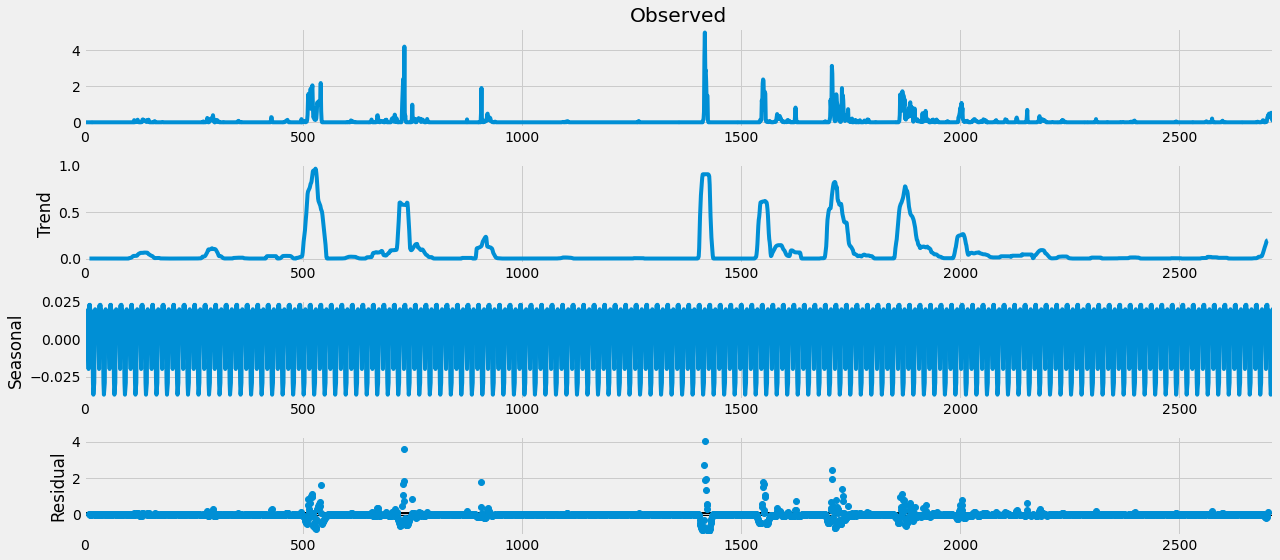

In [81]:
#%% Data Decomposition
#1) Tem sazonalidade forte mas não tem tendencia
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_final_slim["precipitacao"].values, model='additive', period = 24)
fig = decomposition.plot()
plt.show()
plt.close()

In [31]:


# #%% Fit an SARIMAX
# p,d,q = range(5),range(2),range(5)
# pdq = list(itertools.product(p, d, q))
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
# print('Examples of parameter combinations for Seasonal ARIMA...')
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
# print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
# print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
  
# lista_aux_aic = []
# lista_aux_param = []

# #warnings.filterwarnings("ignore")
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         mod = sm.tsa.statespace.SARIMAX(endog=endog,\
#                                            exog=exog,\
#                                             trend='n',\
#                                             order=(param[0],param[1],param[2]),\
#                                             seasonal_order=(param_seasonal[0],param_seasonal[1],param_seasonal[2],param_seasonal[3]))

#         results = mod.fit()
        
#         lista_aux_aic.append(results.aic)
#         lista_aux_param.append([param,param_seasonal])

#         print('SARIMAX: {}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        




In [32]:
from pmdarima.arima.stationarity import ADFTest
from pmdarima.datasets import load_lynx
from pmdarima.arima.utils import nsdiffs
from sklearn.model_selection import TimeSeriesSplit

# Test whether we should difference at the alpha=0.05
# significance level
adf_test = ADFTest(alpha=0.05)
p_val, should_diff = adf_test.should_diff(endog)  # (0.01, False)

In [33]:
nsdiffs(endog,
            m=10,  # commonly requires knowledge of dataset
            max_D=12,
            test='ch')  # -> 0

# or use the OCSB test (by default)
nsdiffs(endog,
        m=10,
        max_D=12,
        test='ocsb')  # -> 0

0

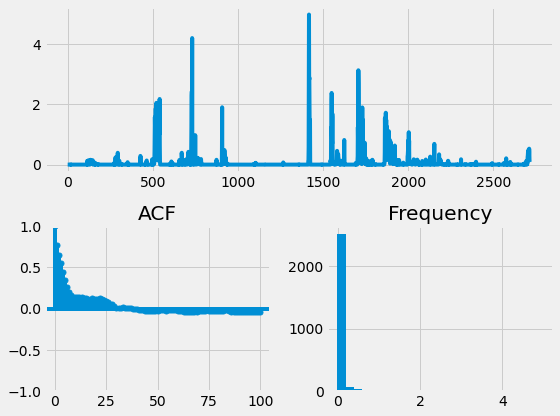

In [82]:
from pmdarima.utils import tsdisplay

tsdisplay(endog, lag_max=100)

In [90]:
import numpy as np
import pmdarima as pm

split = int(endog.shape[0]*0.95)
endog_train = endog[:split]
endog_test = endog[split:]
exog_train = exog[:split]
exog_test = exog[split:]
# fit stepwise auto-ARIMA
stepwise_fit = pm.auto_arima(y=endog_train,X=exog_train, start_p=1, start_q=1,
                             max_p=12, max_q=12,
                            seasonal=False,
                             d=0,max_d=2, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False,
                             random_state=123456,
                             time_varying_regression = True)  # set to stepwise

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=813.701, Time=2.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-304.909, Time=0.76 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-579.691, Time=0.98 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-794.513, Time=1.70 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=-991.972, Time=1.35 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=-1109.666, Time=2.54 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1180.694, Time=1.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1208.314, Time=1.18 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1205.446, Time=1.48 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-1224.623, Time=1.81 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=-1229.734, Time=1.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1206.274, Time=1.24 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1198.460, Time=1.33 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1201.278, Time=1.70 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-1231.578, Time=2.10 sec
 

In [60]:
exog_train

,temperatura,temperatura_aparente,umidade_relativa,pressao
Date,,,,
2022-08-01 00:00:00,14.204102,13.491650,76,1020.6211
2022-08-01 01:00:00,13.917637,13.219508,78,1020.3353
2022-08-01 02:00:00,13.453164,12.778259,80,1020.5142
2022-08-01 03:00:00,13.537734,12.858601,80,1021.7360
2022-08-01 04:00:00,13.426914,12.753322,79,1020.3566
...,...,...,...,...
2022-08-23 16:00:00,20.907891,19.860249,47,1023.3672
2022-08-23 17:00:00,20.655801,19.620764,50,1022.6536
2022-08-23 18:00:00,19.598281,18.616121,58,1021.6887


In [68]:
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
 # seeded from the model we've already fit

def forecast_one_step(X):
    fc, conf_int = stepwise_fit.predict(n_periods=1, return_conf_int=True,X=X)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

y_test = endog_test
y_train = endog_train

for new_ob in y_test:
    i = 0
    exog_test_aux = pd.DataFrame(exog_test.iloc[i]).T
    fc, conf = forecast_one_step(X=exog_test_aux)
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    stepwise_fit.update(y=new_ob,X=exog_test_aux)
    i = i +1

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")


Mean squared error: 0.002491179940666303
SMAPE: 161.5288448732008


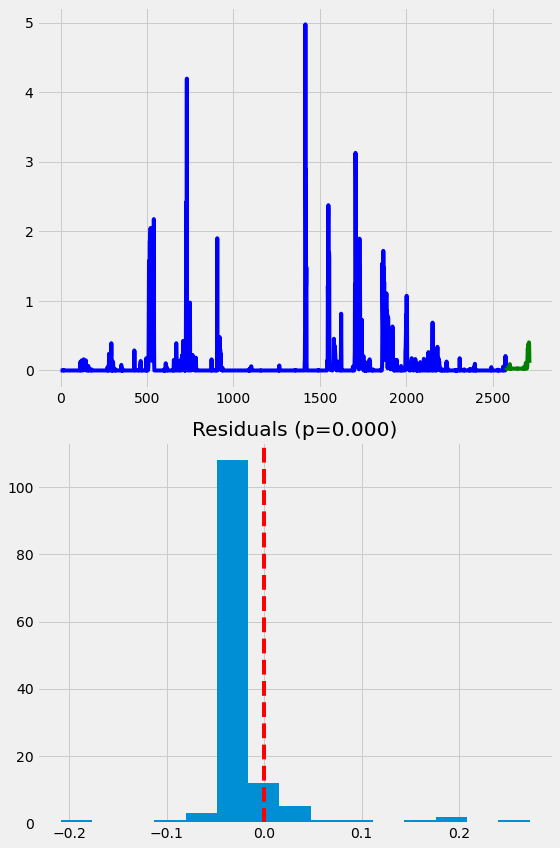

In [84]:
from sklearn.metrics import mean_squared_error as mse

def plot_forecasts(forecasts, figsize=(8, 12)):
    
    forecasts = np.array(forecasts)

    x = np.arange(y_train.shape[0] + forecasts.shape[0])

    fig, axes = plt.subplots(2, 1, sharex=False, figsize=figsize)

    # Plot the forecasts
    axes[0].plot(x[:y_train.shape[0]], y_train, c='b')
    axes[0].plot(x[y_train.shape[0]:], forecasts, c='g')
    #axes[0].set_xlabel(f'Sunspots (RMSE={np.sqrt(mse(y_test, forecasts)):.3f})')

    # Plot the residuals
    resid = endog_test - forecasts
    _, p = normaltest(resid)
    axes[1].hist(resid, bins=15)
    axes[1].axvline(0, linestyle='--', c='r')
    axes[1].set_title(f'Residuals (p={p:.3f})')

    plt.tight_layout()
    plt.show()
    
plot_forecasts(forecasts, figsize=(8, 12))    

In [85]:
from pandas.plotting import autocorrelation_plot

AttributeError: 'Line2D' object has no property 'lag'

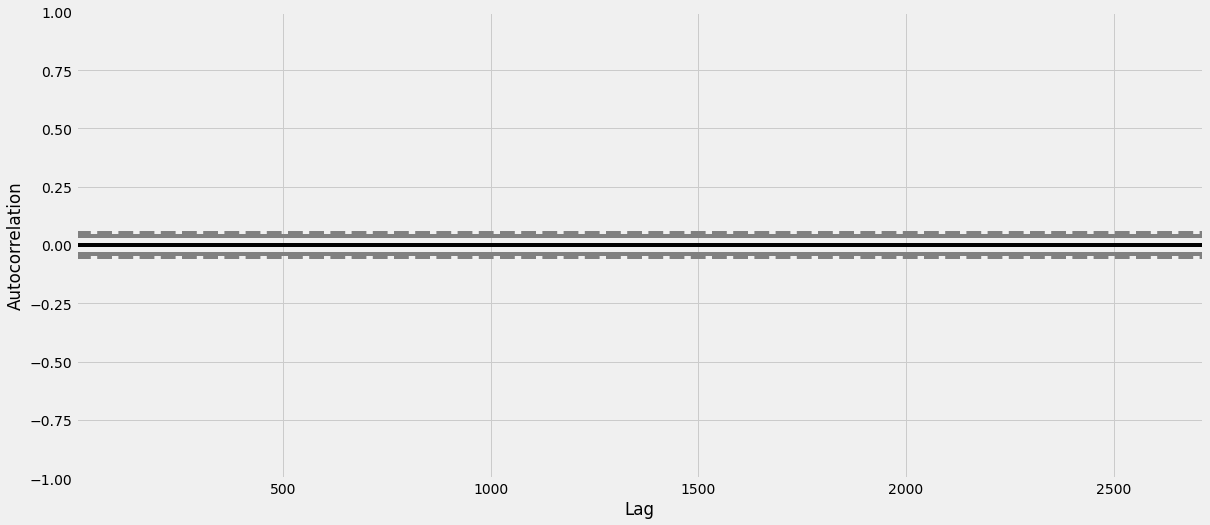

In [89]:
autocorrelation_plot(endog);

In [ ]:
from autots import AutoTS
from datetime import datetime
df_endog = pd.DataFrame(endog)
df_endog = df_endog.drop_duplicates()
#df_endog.index = datetime.fromtimestamp(df_endog.index)

model = AutoTS(forecast_length=12, frequency='infer',ensemble='simple')
model = model.fit(endog.values)
prediction = model.predict()
#make predictions
forecast = prediction.forecast
print("Passengers Forecast")
print(forecast)

AssertionError: df index is not pd.DatetimeIndex

In [ ]:
# Importing packages
import pandas as pd
from atspy import AutomatedModel

# Reading the data:
data = endog

# Preprocessing data 
data.columns = ['month','Passengers']
data['month'] = pd.to_datetime(data['month'],infer_datetime_format=True,format='%y%m')
data.index = data.month
df_air = data.drop(['month'], axis = 1)

# Select the models you want to run:
models = ['ARIMA','Prophet',"NBEATS"]
run_models = AutomatedModel(df = df_air, model_list=models, forecast_len=10)

ModuleNotFoundError: No module named 'torch'

In [ ]:
!pip install sktime

  Using cached numba-0.56.0-cp39-cp39-win_amd64.whl (2.5 MB)
  Using cached llvmlite-0.39.0-cp39-cp39-win_amd64.whl (23.2 MB)


In [41]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError
from sktime.utils.plotting import plot_series , plot_windows , plot_acf , plot_pacf , plot_correlations 
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.statsforecast import StatsForecastAutoARIMA

In [42]:
y_train, y_test = temporal_train_test_split(pd.DataFrame(endog.values), test_size=36)
X_train, X_test = temporal_train_test_split(pd.DataFrame(exog.values), test_size=36)

In [43]:
forecaster = AutoARIMA()
forecaster.fit(y_train,X_train,fh=36)


AutoARIMA()

In [44]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2679
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 683.563
Date:                Tue, 23 Aug 2022   AIC                          -1353.126
Time:                        09:36:01   BIC                          -1311.873
Sample:                             0   HQIC                         -1338.202
                               - 2679                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1186      0.006     19.332      0.000       0.107       0.131
1             -0.1068      0.004    -25.619      0.000      -0.115      -0.099
2              0.0036      0.001      3.763      0.000       0.002       0.005
3             -0.0004      0.000     -4.054      0.000      -0.001      -0.000
ar.L1          0.8003      0.005    160.184      0.000       0.791       0.810
ma.L1         -0.1485      0.006    -23.979      0.000      -0.161      -0.136
sigma2         0.0352      0.000    188.792      0.000       0.035       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1248513.40
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                             4.84
Prob(H) (two-sided):                  0.00   Kurtosis:                       108.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
y_pred = forecaster.predict(X=X_test)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
#mean_absolute_percentage_error(y_test, y_pred, symmetric=False)

NameError: name 'forecaster' is not defined